<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_1_Bab_3_3_9_Memahami_Pengaruh_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [ ]:
data_folder = './data/FMNIST'

train_data = datasets.FashionMNIST(data_folder, download=True, train=True)
val_data = datasets.FashionMNIST(data_folder, download=True, train=False)

tr_images, tr_targets = train_data.data, train_data.targets
val_images, val_targets = val_data.data, val_data.targets

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.6MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 309kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



# Input Kecil tanpa Batch Normalization

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / (255*10000)
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1

    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(100):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 1.7801, Train Accuracy: 0.5476
Validation Loss: 1.2742, Validation Accuracy: 0.5511
Epoch 2
Train Loss: 1.1056, Train Accuracy: 0.6332
Validation Loss: 0.9809, Validation Accuracy: 0.6343
Epoch 3
Train Loss: 0.8964, Train Accuracy: 0.7116
Validation Loss: 0.8326, Validation Accuracy: 0.7064
Epoch 4
Train Loss: 0.7831, Train Accuracy: 0.7317
Validation Loss: 0.7556, Validation Accuracy: 0.7270
Epoch 5
Train Loss: 0.7212, Train Accuracy: 0.7437
Validation Loss: 0.7151, Validation Accuracy: 0.7382
Epoch 6
Train Loss: 0.6843, Train Accuracy: 0.7582
Validation Loss: 0.6770, Validation Accuracy: 0.7536
Epoch 7
Train Loss: 0.6579, Train Accuracy: 0.7640
Validation Loss: 0.6656, Validation Accuracy: 0.7556
Epoch 8
Train Loss: 0.6371, Train Accuracy: 0.7724
Validation Loss: 0.6354, Validation Accuracy: 0.7655
Epoch 9
Train Loss: 0.6204, Train Accuracy: 0.7764
Validation Loss: 0.6267, Validation Accuracy: 0.7696
Epoch 10
Train Loss: 0.6046, Train Accuracy: 0.7747
Validation L

<ipython-input-8-51e033522ec3>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


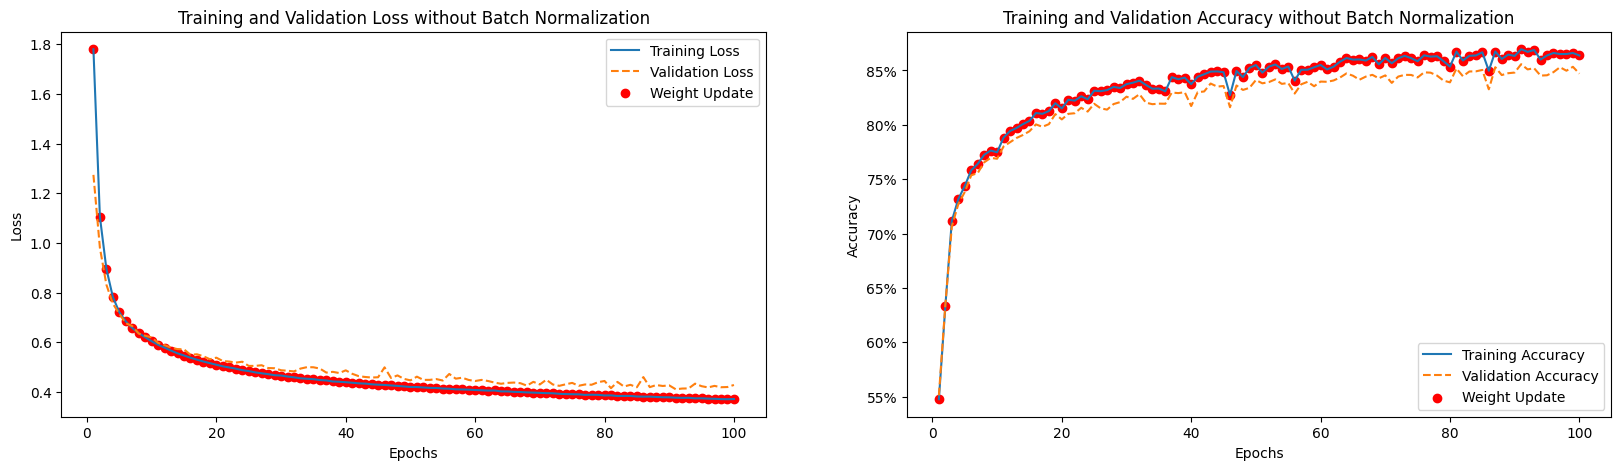

In [ ]:
epochs = np.arange(100) + 1

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss without Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy without Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()

Text(0.5, 1.0, "Hidden layer node values' distribution")

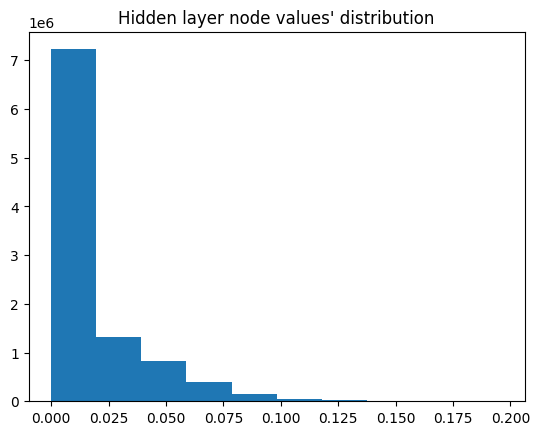

In [ ]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution")

plt.show()

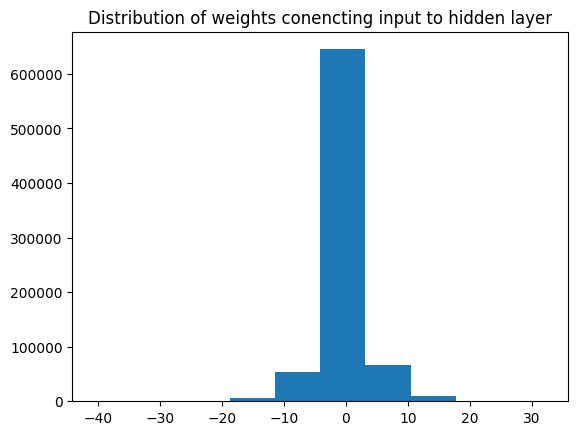

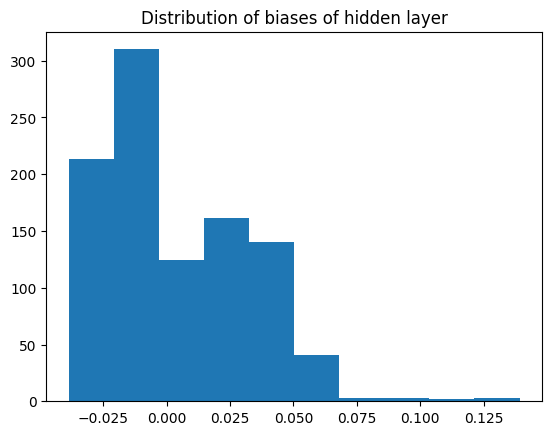

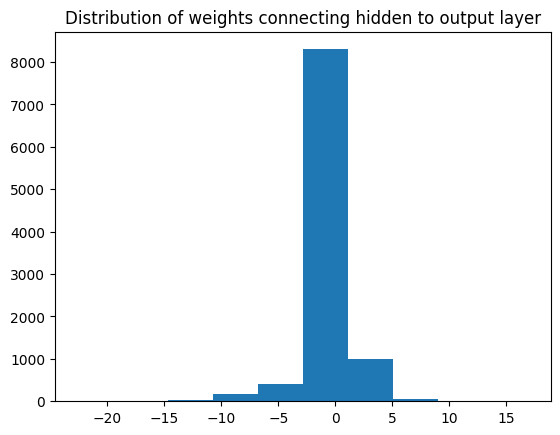

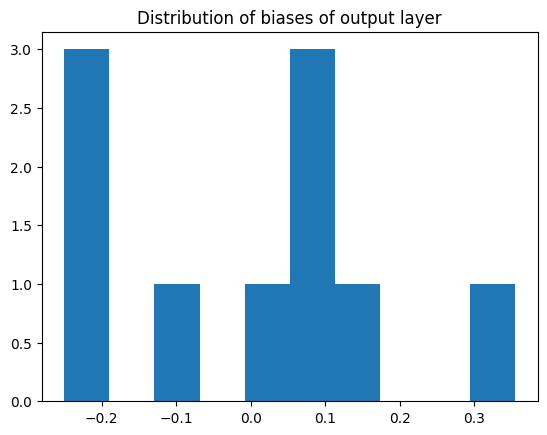

In [ ]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of weights connecting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of biases of output layer')
      plt.show()

# Input Kecil dengan Batch Normalization

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / (255*10000)
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1

    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(100):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 0.5565, Train Accuracy: 0.3307
Validation Loss: 2.5392, Validation Accuracy: 0.3279
Epoch 2
Train Loss: 0.8744, Train Accuracy: 0.7653
Validation Loss: 0.6460, Validation Accuracy: 0.7555
Epoch 3
Train Loss: 0.5980, Train Accuracy: 0.7925
Validation Loss: 0.5878, Validation Accuracy: 0.7820
Epoch 4
Train Loss: 0.5618, Train Accuracy: 0.8031
Validation Loss: 0.5523, Validation Accuracy: 0.7953
Epoch 5
Train Loss: 0.5331, Train Accuracy: 0.8133
Validation Loss: 0.5413, Validation Accuracy: 0.8032
Epoch 6
Train Loss: 0.5074, Train Accuracy: 0.8217
Validation Loss: 0.5184, Validation Accuracy: 0.8133
Epoch 7
Train Loss: 0.4995, Train Accuracy: 0.8323
Validation Loss: 0.5025, Validation Accuracy: 0.8202
Epoch 8
Train Loss: 0.4905, Train Accuracy: 0.8360
Validation Loss: 0.4811, Validation Accuracy: 0.8252
Epoch 9
Train Loss: 0.4793, Train Accuracy: 0.8423
Validation Loss: 0.4768, Validation Accuracy: 0.8298
Epoch 10
Train Loss: 0.4700, Train Accuracy: 0.8322
Validation L

<ipython-input-10-76eea90b641c>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


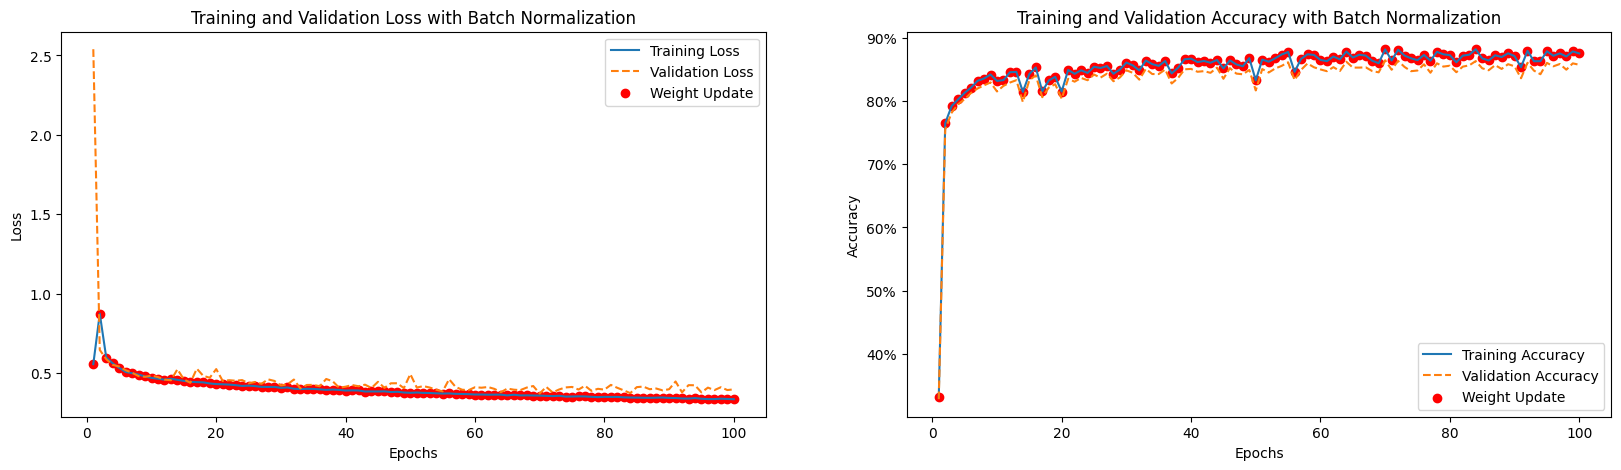

In [ ]:
epochs = np.arange(100) + 1

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss with Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy with Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()

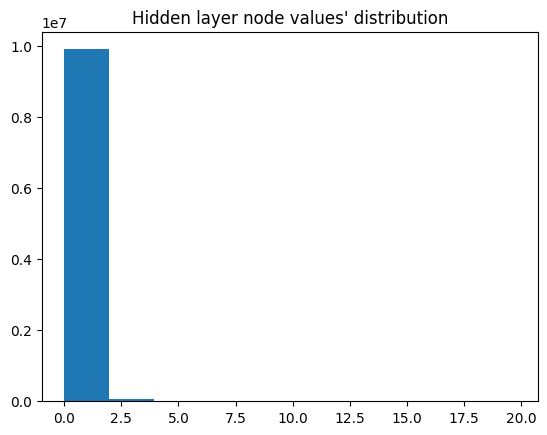

In [ ]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution")

plt.show()

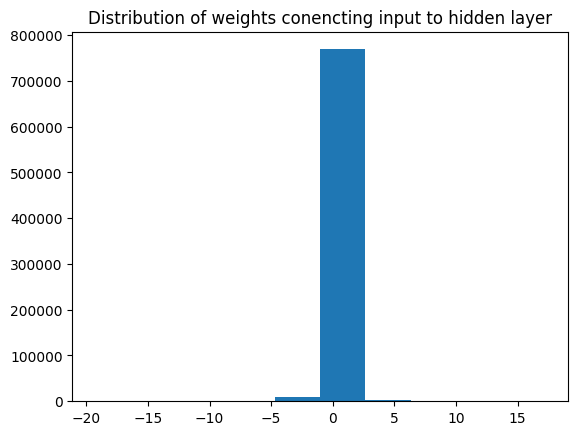

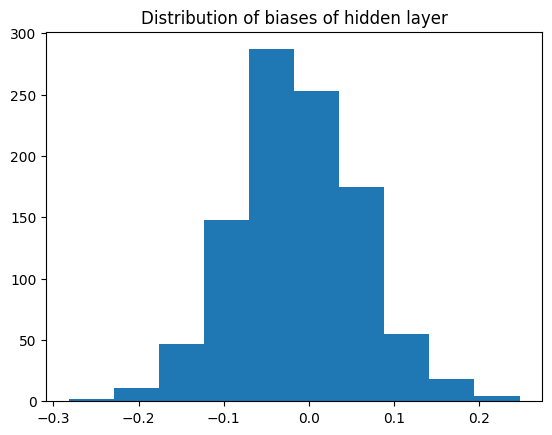

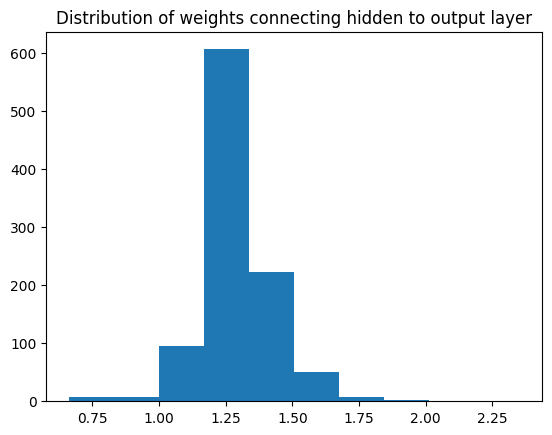

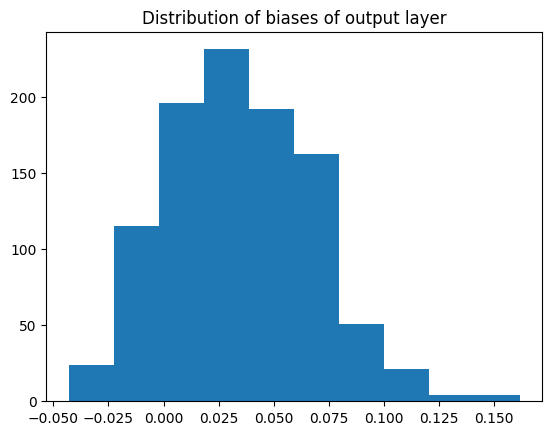

In [ ]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of weights connecting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      plt.title('Distribution of biases of output layer')
      plt.show()